# **Predictive Modeling, Customer Lifetime Revenue**

## **Step 0: Overview**

### **Problem Statement**:
In order for us to be able to optimize our acquisition marketing efforts, we
would like to better understand and get an early read of how valuable our new users are to us. This will allow us to allocate our budget strategically and target prospective customers efficiently via our best performing channels. It will also give us a better insight into how much we can spend to acquire new customers via different channels.


The task here is to build a predictive model to be able to predict 12 month revenue of our new users within 15 days of them signing up and bucket them into High-Value, Medium-Value and Low-Value tiers.

**Data (Customer Attributes)**


| Sl. | Field Name | Field Description |
| :- | :- | :- |
|1.| customer_id|Unique customer ID|
|2.|dob|Data of Birth|
|3.|state|Customer’s State|
|4.|userType|Type of Customer|
|5.|profileStatus|Status of the Profile Created|
|6.|verificationStatus|Status of KYC Verification|
|7.|createdAt|Customer ID Created At|
|8.|incomeSurveySource|Source of Income from onboarding in-app survey|
|9.|incomeSurveyAmount|Source of Income from onboarding in-app survey|
|10.| firstSwitchTimestamp|Timestamp of setting up payroll deposit|
|11.| firstPayrollTimestamp|Timestamp of receiving first payroll deposit in the account|
|12.| userVerifiedTimestamp|Timestamp of completing KYC process(Sign up completed = User Verified)|
|13.| ageAtUserVerified|Customer's age at the time of Verification/KYC|
|14.| ageAtFirstSwipe|Customer's age at the time of of their first card swipe|
|15.| firstSessionOs|Device OS name|
|16.| isTeenUser|Flag to identify a Teen user. Teen users can not do KYC but can transact when their parents sign up.|
|17.| context_os_name|Device OS Name|
|18.| context_device_model|Device|
|19.| context_device_ad_tracking_enabled|If they have enabled ad tracking on their device/app|
|20.| context_device_manufacturer|Device Manufacturer|
|21.| context_device_type|Device Type|
|22.| context_network_carrier|Device Network Carrier|
|23.| physical_card_activated_at|Physical Debit Card Activation time|
|24.| virtual_card_activated_at|Virtual Debit Card Activation time|
|25.| attributed_channel_verified|Marketing Channel or Source they were attributed to|
|26.| Tuid|Transaction Id of the transaction made by user, admin or the system|
|27.| effectiveTimestamp|Effective timestamp of the transaction|
|28.| Amount|Transaction amount in cents if usd|
|29.| isQualifiedTransaction|If a transaction is qualified as a user generated transaction e.g.swipe, deposit, atm withdrawal,etc|
|30.| transactionCode|Code of a transaction|
|31.| transactionType|Type of transaction|
|32.| failedDate|Failed date of the transaction|
|33.| failureReasonList|Failure reason if any|
|34.| Currency|currency of the transaction, USD, Crypto, Points, etc|
|35.| Action|Transaction Action|
|36.| cardType|Type of Card|
|37.| disputeCreatedAt|Dispute date of a transaction|
|38.| Mcc|Merchant Category Code|
|39.| mccDescription|Merchant Category Description|
|40.| walletType|Type of user wallet e.g. Primary, Crypto, Savings, etc|

### **Solution Overview**

Supervised Machine Learning models (Regression and Classification) will be built that will generate two key outputs based on a customer’s first 15 days of activity:

- **Model-1: Revenue Prediction (Regression)**: Develop a supervised regression model to **predict the total revenue over the first 12 months for new users**. Target label will be the first 12 months' revenue total.

- **Model-2: Customer Tier Prediction (Classification)**: Build a supervised classification model to predict the **customer revenue tier (High, Medium, Low)**. Target labels will be created using quantile binning of the 1-year revenue.


### **Assumptions**
- **Customer Value Tier Considerations**: The customer value tier will be determined based on quantile binning of the predicted 12-month revenue, categorizing customers into High, Medium, and Low-value segments.

- **Lifetime Revenue**: In the absence of detailed revenue sources such as fees, interest, and financial charges, the total transaction amount (across all transaction types) will be used as a proxy for the customer's lifetime revenue.

- **Credit/Debit Revenue**: Ideally, identifying credit and debit transactions would provide insights into a customer's average periodic balance. However, due to incomplete transaction history (e.g., missing initial balance details), attempts to classify transactions by type were inconclusive. As a result, detailed credit/debit analysis was not incorporated into the data preparation phase.

- **Customer Acquisition Cost by Channel**: Although information on acquisition costs per channel would enhance cost-value analysis, this data is unavailable. Therefore, channels with higher customer acquisition rates, particularly those with more high-value customers, are assumed to be more valuable.

- **15-Day Activity Window**: Given the incomplete transaction records for all customers, particularly within the first 15 days, the analysis assumes the first 15 transaction dates as the initial activity period for each customer.

- **Zero Value Transactions**: There are two types of zero-value transactions: valid transactions with zero value and failed transactions. While failed zero-value transactions are understandable, valid ones ideally should have a monetary value. Due to a lack of clarity, zero-value transactions are excluded from the analysis rather than applying imputation.

- **Feature Engineering**: The focus of feature engineering is on early activity metrics within the first 15 days, under the assumption that these are predictive of long-term customer value.

### **Solution Steps**
#### **Step 1: Data Understanding (Exploratory Data Analysis)**
- **Data Collection**
  - Data Loaded as per the given file.
  - Separate Customer and Transaction records for ease of analysis.

- **Descriptive Statistics/Visual EDA**
  - Missing Value percentage by variables.
  -Below are some of the breakdown of categorical variables with respect to percentage of customer acquired:
    - **States**: TX(9.35%), CA(9.21%) and FL(6.85%) are some of the top states.
    - **Profile Status**: There are 86% customer records with VERIFIED status, rest are either SUSPENDED, DEACTIVATED, FLAGGED. We can use only VERIFIED customers for data accuracy.
    - **firstSesssionOs**: Most of this variable value are UNKNOWN(99.8%). Hence can be skipped during subsequent steps.
    - **Attributed Channels**: Organic (15.71%), Referral(14.34%) and Influencer(13.29%) are the most efficient channels in terms of number of acquired customer.
    
#### **Step 2: Data Preparation**
- **Data Cleaning**
  - **Missing**: Drop variables with lot of missing values e.g
  - **Imputations**: Use median for numerical and mode for categorical variables.
  - **Filters**: Below data filters are used:
    - **VERIFIED Customers**: Only Pick Customers whose profile is VERIFIED.
    - **No Transations**: Exclude customers with no transaction.
    - **Failed/Zero Value Transactions**: Exclude failed transactions and those with ZERO dollar value.
    - **Low/No Variance** - Skip some categorical variables where there is just one unique values and numerical variables with zero variance.
- **Data Transform**
  - **Date Fields** - Date variables are converted to datetime formats to be used for further processing.
  - **Categorical Encoding**- Categorical variables such as State, Channels, Transaction Type, WalletType etc. are encoded using One-Hot-Encoding.
  - **Numerical Scaling** - Numerical variables are scaled using standard scaler.
- **Feature Engineering**

  There are some features created from the input variables.
  
  - **Customer Features**
    - **userType** - Based on Age assign types as Individual/Minor
    - **days_to_first_switch** - Numer of days from onboarding to make the first switch.
    - **days_to_first_payroll** - Numer of days from activation to first payroll deposit.
    - **days_to_phy_card_activate** - Numer of days from account opening to physical card activation.
    - **days_to_vir_card_activate** - Numer of days from account opening to physical card activation.

  - **Transaction Features**

      These features are aggregated by Customer's first **15 days** activities

    - **cnt_tran_15d** - Total Number of transactions by Customer
    - **tot_revenue_15d** Total revenue from first 15 days.
    - **amount_mean_[walletType]** - Average amount of transactions by walletType
    - **amount_mean_[transactionType]** - Average amount of transactions by walletType
    - **amount_total_[walletType]** - Total amount of transactions by walletType
    - **amount_total_[transactionType]** - Total amount of transactions by walletType
    - **tuid_count_[walletType]** - Number of transactions by Wallet Type.
    - **tuid_count_[transactionType]** - Number of transactions by Transaction Type.

    This feature will be aggregated by customer transactions from first 365 days.
    - **tot_revenue_1Yr** Total revenue from first 365 days.
    - **customer_tier** Based on toal_revenue_1Yr assign a quanitle bin.


#### **Step 3: Modeling**
- **Target Variables**

  - **Model-1 (Regression)** - Total Revenue for first 365 days.
  - **Model-2 (Classification)** - Customer tier based on 3 Quantiles.

- **Feature Selection**
  
  - The model will be trained with all features and once model is validated few significant features will be picked to train the final model.
  - Consider features which can be derived from 15days customer activities, since those will be the input to the productionized model.

- **Model Building/Training**
  - Consider models like Random Forest, Gradient Boosting, or XGBoost that handle non-linearity and interactions well.
  - Also, explore models like Linear Regression or Ridge Regression as a baseline.
  - **Random Forest** is chosen for its robustness against overfitting and ability to handle a large number of features.
  
- **Model Evaluation**
  - Regression model was evaluated via **Mean Absolute Error (MAE)** and **Mean Absolute Percentage Error (MAPE)**.
  - Classification model was evaluated via **Accuracy** and **AUC scores**.
- **Model Selection**
  - Final model will be selected and trained with specific set of important features as described in Feature Selection.

#### **Step 4: Conclusion**
  Two predictive models were developed: a regression model to forecast 12-month revenue and a classification model to categorize customers into value tiers (High, Medium, Low). The regression model achieved a strong performance with a MAPE score of ~10, indicating its reliability in predicting long-term customer value. The classification model also performed well, with an AUC score of ~0.80, effectively distinguishing between high, medium, and low-value customers.

  These models provide a robust framework for early identification of high-value customers within the first 15 days of signup. By leveraging these predictions, marketing efforts can be optimized, enabling more strategic allocation of acquisition budgets and enhancing overall customer targeting strategies. This data-driven approach is instrumental in maximizing ROI on customer acquisition and improving long-term profitability.

- **Model Performance**:
  - Regression Model: Predicts 12-month revenue with a **Mean Absolute Percentage Error (MAPE) of ~10**.
  - Classification Model: Predicts customer tier (High, Medium, Low) with an **AUC score of ~0.80**.

- **Top Features Influencing Regression Model**:
  - amount_sum_PRIMARY: Total transaction amount in the primary wallet.
  - tuid_cnt_transfer: Number of transfer transactions.
  - days_to_first_payroll: Days from onboarding to first payroll deposit.
  - tuid_cnt_SAVINGS: Number of savings transactions.
  - amount_sum_deposit: Total deposit transaction amount.

- **Top Features Influencing Classification Model**:
 - amount_sum_PRIMARY: Total transaction amount in the primary wallet.
 - cnt_tran_15d: Total number of transactions in the first 15 days.
 - amount_sum_deposit: Total deposit transaction amount.
 - amount_mean_deposit: Average deposit transaction amount.
 - amount_sum_card: Total card transaction amount.

- **Enhancements/Recommendation**
  - **Attrition**: There are customers whose 1st 15D revenue and 1Y revenue are same. These could be potential case of soft attrition or may be some long term investment products e.g Time Deposits. If any of those are HIGH value, more analysis is needed whether those can be included part of this model.

  - **ZERO Value Tranactions** - Analyze transactions that seems valid but have ZERO dollar value, seems to be data issue. In absence of a data resolution appropriate imputation logic can be applied in consultation with business/product.
  
  - **Closed Accounts**: There are accounts with transaction type ACCOUNT_CLOSURE, make sure closed accounts are not impacting overall model.

  - **More Research Data**: For better research, transaction activity data from customer inception will be helpfull. For example some customers, the first transactions are WITHDRAWAL, this won't suggest about the prior balance on that account.

## **Step 1: Data Understanding**
Exploratory Data Analysis (EDA)

### 0. Standard Imports and Functions:

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime as dt

In [ ]:
# Categorical Variable Distribution plots

def plot_catg_distribution(fig, df, sInpVar, nRow, nCol):

  s = (df[sInpVar].value_counts(normalize=True)*100).round(2)
  s.sort_values(ascending=False, inplace=True)

  lstIndex = [str(l)[:20] for l in s.index[:10]]
  plot_y = lstIndex
  plot_x = s.values[:10]

  fig.add_trace(
    go.Bar(x=plot_x, y=plot_y, name=sInpVar, orientation='h'),
    row=nRow, col=nCol
    )

# Numerical Variable distribution plot
def plot_numerical_variable_distribution(df, sIDColumn, lstVariables):
  # Melt the DataFrame to have one value column and a variable identifier
  df_melted = df.melt(id_vars=[sIDColumn], value_vars=lstVariables,
                      var_name='Variable', value_name='Value')

  # Create the box plot
  fig = px.box(df_melted, x='Variable', y='Value', points='all')

  # Customize the plot
  fig.update_layout(
      title="Numerical Variable Distribution",
      xaxis_title="Variables",
      yaxis_title="Value",
      template="plotly"
  )

  # Show the plot
  fig.show()

  # Test
  # plot_numerical_variable_distribution(df_cust, 'customer_id', lstCustFetrsNum)

# Missing Value Check
def missing_value_check(df):
  s_null = (df.isnull().sum()/df.shape[0])*100
  s_null = s_null[s_null>20].round(2)
  s_null.sort_values(ascending=True, inplace=True)

  # Create a bar plot with labels
  fig = px.bar(s_null, x=s_null, y=s_null.index, text_auto=True,
              labels={'index': 'Variables', 'x': '%Missing Values'},
              title='Variable Missing Percentages')

  # Show the plot
  fig.show()


# Create a Function to process datetime fields
def format_str_to_date(strInpDt):
    strInpDt = str(strInpDt)

    if strInpDt.lower() in ['nan','nat']:
        dtOutDate = None
    else:
        if len(strInpDt) == 10:
            dtOutDate = dt.strptime(strInpDt, '%Y-%m-%d')
        else:
            strInpDt = strInpDt[:19]
            dtOutDate = dt.strptime(strInpDt, '%Y-%m-%d %H:%M:%S')

    return dtOutDate

# Test
# strDt = '2022-05-15'
# print(format_str_to_date(strDt))

### 1. Load Data

In [ ]:
df = pd.read_csv('LTR Modeling Excercise Sample Data.csv')

print(df.shape)
df.head()

(1500000, 40)


,customer_id,dob,state,userType,profileStatus,verificationStatus,createdAt,incomeSurveySource,incomeSurveyAmount,firstSwitchTimestamp,...,transactionType,failedDate,failureReasonList,currency,action,cardType,disputeCreatedAt,mcc,mccDescription,walletType
0,hDZoU9xpN2TRHftiYs9SYAJlnBYHmdyIQtv3zD1gNAw=,2004-03-13,MA,NaN,VERIFIED,VERIFIED,2022-05-15 21:54:53.619 UTC,NaN,NaN,NaN,...,card,1.654288e+12,NaN,USD,NaN,UNKNOWN_CARD_TYPE,0.0,5967.0,Direct Marketing - Inbound Teleservices Merchant,PRIMARY
1,hDZoU9xpN2TRHftiYs9SYAJlnBYHmdyIQtv3zD1gNAw=,2004-03-13,MA,NaN,VERIFIED,VERIFIED,2022-05-15 21:54:53.619 UTC,NaN,NaN,NaN,...,deposit,NaN,NaN,USD,NaN,UNKNOWN_CARD_TYPE,0.0,NaN,NaN,PRIMARY
2,hDZoU9xpN2TRHftiYs9SYAJlnBYHmdyIQtv3zD1gNAw=,2004-03-13,MA,NaN,VERIFIED,VERIFIED,2022-05-15 21:54:53.619 UTC,NaN,NaN,NaN,...,deposit,NaN,NaN,USD,NaN,UNKNOWN_CARD_TYPE,0.0,NaN,NaN,PRIMARY
3,hDZoU9xpN2TRHftiYs9SYAJlnBYHmdyIQtv3zD1gNAw=,2004-03-13,MA,NaN,VERIFIED,VERIFIED,2022-05-15 21:54:53.619 UTC,NaN,NaN,NaN,...,card,1.664603e+12,NaN,USD,NaN,UNKNOWN_CARD_TYPE,0.0,5967.0,Direct Marketing - Inbound Teleservices Merchant,PRIMARY
4,hDZoU9xpN2TRHftiYs9SYAJlnBYHmdyIQtv3zD1gNAw=,2004-03-13,MA,NaN,VERIFIED,VERIFIED,2022-05-15 21:54:53.619 UTC,NaN,NaN,NaN,...,card,1.654288e+12,NaN,USD,NaN,UNKNOWN_CARD_TYPE,0.0,5967.0,Direct Marketing - Inbound Teleservices Merchant,PRIMARY


### 2. Data Exploration:
Data Exploration and Cleaning:
- Check for missing values, duplicates, and data types.
- Handle missing values by either imputing them (mean, median, mode) or removing the rows/columns if appropriate.
- Convert timestamps to datetime objects, and create derived features like days since sign-up.
- Handle categorical variables like state, userType, profileStatus using one-hot encoding or label encoding.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500000 entries, 0 to 1499999
Data columns (total 40 columns):
 #   Column                              Non-Null Count    Dtype  
---  ------                              --------------    -----  
 0   customer_id                         1500000 non-null  object 
 1   dob                                 1499999 non-null  object 
 2   state                               1500000 non-null  object 
 3   userType                            1825 non-null     object 
 4   profileStatus                       1500000 non-null  object 
 5   verificationStatus                  1500000 non-null  object 
 6   createdAt                           1500000 non-null  object 
 7   incomeSurveySource                  27022 non-null    object 
 8   incomeSurveyAmount                  27022 non-null    object 
 9   firstSwitchTimestamp                728086 non-null   object 
 10  firstPayrollTimestamp               1074204 non-null  object 
 11  userVerifie

In [ ]:
# Customer Features
sCustomerID = 'customer_id'

lstCustFetrs = ['customer_id', 'dob', 'state', 'userType', 'profileStatus',
                'verificationStatus', 'createdAt', 'incomeSurveySource',
                'incomeSurveyAmount', 'firstSwitchTimestamp', 'firstPayrollTimestamp',
                'userVerifiedTimestamp', 'ageAtUserVerified', 'ageAtFirstSwipe',
                'firstSessionOs', 'isTeenUser', 'context_os_name',
                'context_device_model', 'context_device_ad_tracking_enabled',
                'context_device_manufacturer', 'context_device_type',
                'context_network_carrier', 'physical_card_activated_at',
                'virtual_card_activated_at', 'attributed_channel_verified']

# Customer Categorical Features
lstCustFetrsCatg = ['state', 'userType', 'profileStatus', 'verificationStatus', 'incomeSurveySource',
                    'firstSessionOs', 'isTeenUser', 'context_os_name','context_device_model',
                    'context_device_ad_tracking_enabled','context_device_manufacturer',
                    'context_device_type','context_network_carrier', 'attributed_channel_verified']

# Customer Numerical Features
lstCustFetrsNum = ['incomeSurveyAmount', 'ageAtUserVerified', 'ageAtFirstSwipe']

# Customer DateTime Features
lstCustFetrsDate = ['dob','createdAt', 'firstSwitchTimestamp', 'firstPayrollTimestamp',
                    'userVerifiedTimestamp', 'physical_card_activated_at', 'virtual_card_activated_at']

sTransactionID = 'tuid'

# Transaction Features
lstTranFetrs = ['tuid','effectiveTimestamp', 'amount', 'isQualifiedTransaction','transactionCode',
                'transactionType', 'failedDate', 'failureReasonList', 'currency', 'action',
                'cardType', 'disputeCreatedAt', 'mcc', 'mccDescription', 'walletType']

# Transactions Categorical Features
lstTranFetrsCatg = ['isQualifiedTransaction','transactionCode', 'transactionType',
                    'failureReasonList', 'currency', 'action', 'cardType', 'mcc', 'mccDescription', 'walletType']

# Transactions Numerical Features
lstTranFetrsNum  = ['amount']

# Transactions DateTime Features
lstTranFetrsDate  = ['effectiveTimestamp', 'failedDate', 'disputeCreatedAt']

In [ ]:
# Drop records with no transactions (it's a small percentage of transactions)
print(df['tuid'].isnull().sum())
df = df[df['tuid'].isnull()==False]
print(f"Verify data count post drop: {df.shape}")

3824
Verify data count post drop: (1496176, 40)


#### **Customer Data**
Separate distinct Customer Data for analysis.

In [ ]:
df_cust = df[lstCustFetrs].drop_duplicates()
print(df_cust.shape)
df_cust.head()

(4526, 25)


,customer_id,dob,state,userType,profileStatus,verificationStatus,createdAt,incomeSurveySource,incomeSurveyAmount,firstSwitchTimestamp,...,isTeenUser,context_os_name,context_device_model,context_device_ad_tracking_enabled,context_device_manufacturer,context_device_type,context_network_carrier,physical_card_activated_at,virtual_card_activated_at,attributed_channel_verified
0,hDZoU9xpN2TRHftiYs9SYAJlnBYHmdyIQtv3zD1gNAw=,2004-03-13,MA,NaN,VERIFIED,VERIFIED,2022-05-15 21:54:53.619 UTC,NaN,NaN,NaN,...,False,iOS,"iPhone14,3",False,Apple,ios,Verizon,2022-05-23 20:55:07.482 UTC,2022-05-16 02:19:50.931 UTC,organic
5,xxCPDvLOMcK+EZ6oMlKzhJxEWgGz7vL3fL/54XvUwxM=,2002-08-03,MA,NaN,VERIFIED,VERIFIED,2022-05-23 21:15:57.415 UTC,NaN,NaN,2022-07-17 15:15:19.894 UTC,...,False,iOS,iPhone XR,True,Apple,ios,T-Mobile,2022-06-14 02:10:00.779 UTC,2022-10-04 03:32:55.927 UTC,affiliate
151,uUEOPxGvjk4cIU7DSfaWhDLLO71o8exdCi3mEoynJdU=,1987-01-10,MA,NaN,VERIFIED,VERIFIED,2022-05-09 16:12:59.286 UTC,NaN,NaN,NaN,...,False,iOS,"iPhone13,2",True,Apple,ios,T-Mobile,2022-05-16 17:22:05.823 UTC,2022-05-09 16:13:40.538 UTC,google non-brand search
165,9DTDesdsp/c9lbRCicwW1yzh7+BsbkUndyiqtuQBjd0=,2000-04-04,NJ,NaN,VERIFIED,VERIFIED,2022-05-18 18:17:25.901 UTC,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-18 18:18:52.092 UTC,direct-mail
190,vMRe6hgkpBx1qXNRdYOHQsfP81KMBSpMwWmWmDjc+5k=,1999-10-11,NC,NaN,VERIFIED,VERIFIED,2022-05-08 22:51:03.734 UTC,NaN,NaN,NaN,...,False,iOS,"iPhone13,4",False,Apple,ios,AT&T,2022-05-13 22:54:49.602 UTC,2024-03-25 12:28:26.021 UTC,organic


**Customer - Missing Value Check**

In [ ]:
# Missing Value Check
missing_value_check(df_cust)

In [ ]:
# # Variables with higher null percentage can be flagged to be dropped.
# # 'userType' will be derived at a later step
lstDropFetrs = ['incomeSurveySource', 'incomeSurveyAmount']

**Customer Categorical Features**

In [ ]:
# Let's see some categorical variable stats
df_cust[lstCustFetrsCatg].describe().T

,count,unique,top,freq
state,4526,53,TX,423
userType,9,2,individual,8
profileStatus,4526,4,VERIFIED,3904
verificationStatus,4526,1,VERIFIED,4526
incomeSurveySource,63,5,Direct Deposit,29
firstSessionOs,4525,3,UNKNOWN_PLATFORM,4516
isTeenUser,4526,1,False,4526
context_os_name,3504,2,iOS,2219
context_device_model,3504,364,"iPhone12,1",369
context_device_ad_tracking_enabled,3494,2,True,2071


In [ ]:
# Variables with just one unique values can be dropped (e.g. verificationStatus, isTeenUser)
# Variables with just one unique values can be dropped (e.g. firstSessionOs is mostly UNKNOWN)

lstDropFetrs += ['verificationStatus', 'isTeenUser', 'firstSessionOs']
# lstDropFetrs

In [ ]:
df_cust.columns

Index(['customer_id', 'dob', 'state', 'userType', 'profileStatus',
       'verificationStatus', 'createdAt', 'incomeSurveySource',
       'incomeSurveyAmount', 'firstSwitchTimestamp', 'firstPayrollTimestamp',
       'userVerifiedTimestamp', 'ageAtUserVerified', 'ageAtFirstSwipe',
       'firstSessionOs', 'isTeenUser', 'context_os_name',
       'context_device_model', 'context_device_ad_tracking_enabled',
       'context_device_manufacturer', 'context_device_type',
       'context_network_carrier', 'physical_card_activated_at',
       'virtual_card_activated_at', 'attributed_channel_verified'],
      dtype='object')

In [ ]:
# Categorical Variable Distribution plots
lstCatgVariables = ['state', 'profileStatus', 'incomeSurveySource', 'firstSessionOs', 'attributed_channel_verified',
                    'context_os_name', 'context_device_model', 'context_device_manufacturer', 'context_device_type',
                    'context_network_carrier']

fig = make_subplots(rows=5, cols=2, subplot_titles=lstCatgVariables)

nRow, nCol = 1,1
for sInpVar in lstCatgVariables:
  plot_catg_distribution(fig, df_cust, sInpVar, nRow, nCol)
  nCol += 1
  if nCol > 2:
    nCol = 1
    nRow += 1

# Update layout
fig.update_layout(height=1500, width=1200, title_text="Categorical Distribution by %Cusomer", showlegend=False)

fig.show()

**Customer Numerical Features**

In [ ]:
df_cust[lstCustFetrsNum].describe()

,ageAtUserVerified,ageAtFirstSwipe
count,4526.000000,2767.000000
mean,31.474812,30.060716
std,11.887638,10.860214
min,18.000000,13.000000
25%,22.000000,22.000000
50%,28.000000,27.000000
75%,38.000000,36.000000
max,98.000000,84.000000


In [ ]:
# Numerical Variable distribution
plot_numerical_variable_distribution(df_cust, 'customer_id', lstCustFetrsNum)

In [ ]:
# Variables with higher null percentage can be flagged to be dropped.
# 'userType' will be derived at a later step

lstDropFetrs += ['incomeSurveySource', 'incomeSurveyAmount']

#### **Transaction Data**

In [ ]:
df_tran = df[['customer_id'] + lstTranFetrs]
print(df_tran.shape)
df_tran.head()

(1496176, 16)


,customer_id,tuid,effectiveTimestamp,amount,isQualifiedTransaction,transactionCode,transactionType,failedDate,failureReasonList,currency,action,cardType,disputeCreatedAt,mcc,mccDescription,walletType
0,hDZoU9xpN2TRHftiYs9SYAJlnBYHmdyIQtv3zD1gNAw=,RlUYjsLIETCee2cWY9bmUPoszQ53P8ji+61T5DfXETs=,2022-06-03 20:25:16.152 UTC,0.0,False,PURCHASE,card,1.654288e+12,NaN,USD,NaN,UNKNOWN_CARD_TYPE,0.0,5967.0,Direct Marketing - Inbound Teleservices Merchant,PRIMARY
1,hDZoU9xpN2TRHftiYs9SYAJlnBYHmdyIQtv3zD1gNAw=,MGWrMopf0zkGE/jj/9rFGSqKSclAdU3jCAD9T6076FU=,2022-06-10 15:09:07.412 UTC,28000.0,True,EARLY_RDFI,deposit,NaN,NaN,USD,NaN,UNKNOWN_CARD_TYPE,0.0,NaN,NaN,PRIMARY
2,hDZoU9xpN2TRHftiYs9SYAJlnBYHmdyIQtv3zD1gNAw=,88UXUQLS79+W5ys++BmGw9Fkhi26xcBSLSNGGqYIrDY=,2022-07-05 01:06:00.967 UTC,6000.0,True,RDFI_DEPOSIT,deposit,NaN,NaN,USD,NaN,UNKNOWN_CARD_TYPE,0.0,NaN,NaN,PRIMARY
3,hDZoU9xpN2TRHftiYs9SYAJlnBYHmdyIQtv3zD1gNAw=,nwC7tHsTfSNWT4r0tO1dM9qTi4UcxubxSY/j8jrckeI=,2022-10-01 05:40:11.781 UTC,0.0,False,PURCHASE,card,1.664603e+12,NaN,USD,NaN,UNKNOWN_CARD_TYPE,0.0,5967.0,Direct Marketing - Inbound Teleservices Merchant,PRIMARY
4,hDZoU9xpN2TRHftiYs9SYAJlnBYHmdyIQtv3zD1gNAw=,/eMo4+bQoOUMHKATjQH4tDWnAdAdoAxfraL1AaADqq8=,2022-06-03 20:25:43.247 UTC,0.0,False,PURCHASE,card,1.654288e+12,NaN,USD,NaN,UNKNOWN_CARD_TYPE,0.0,5967.0,Direct Marketing - Inbound Teleservices Merchant,PRIMARY


In [ ]:
df_tran['mcc'] = df_tran['mcc'].astype(str)

**Transaction - Missing Value Check**

In [ ]:
# Missing Value Check
missing_value_check(df_tran)

**Transaction - Categorical Features**

In [ ]:
# Transaction Categorical Features
df_tran[['isQualifiedTransaction',
          'transactionCode',
          'transactionType',
          'currency',
          'cardType',
          'mcc',
          'mccDescription',
          'walletType']].describe().T

,count,unique,top,freq
isQualifiedTransaction,1496176,2,True,930460
transactionCode,1496176,32,PURCHASE,672029
transactionType,1496176,7,card,858516
currency,1496176,1,USD,1496176
cardType,1496176,1,UNKNOWN_CARD_TYPE,1496176
mcc,1496176,354,nan,667035
mccDescription,826491,317,Money Orders - Wire Transfer,123378
walletType,1496176,5,PRIMARY,1083324


In [ ]:
# Drop/Ignore variables with just one values (no variance)
# lstDropFetrs += ['currency', 'cardType']

In [ ]:
### Check Transaction Categorical Feature distribution
lstCatgVariables = ['isQualifiedTransaction', 'transactionCode', 'transactionType', 'mcc', 'mccDescription', 'walletType']

fig = make_subplots(rows=3, cols=2, subplot_titles=lstCatgVariables)

nRow, nCol = 1,1
for sInpVar in lstCatgVariables:
  plot_catg_distribution(fig, df_tran, sInpVar, nRow, nCol)
  nCol += 1
  if nCol > 2:
    nCol = 1
    nRow += 1

# Update layout
fig.update_layout(height=1000, width=1100, title_text="Categorical Distribution by %Transaction", showlegend=False)

fig.show()

**Transaction - Numerical Features**

             amount
count  1.496176e+06
mean   2.062365e+04
std    1.395232e+05
min    0.000000e+00
25%    2.000000e+00
50%    4.560000e+02
75%    8.000000e+03
max    7.500000e+07


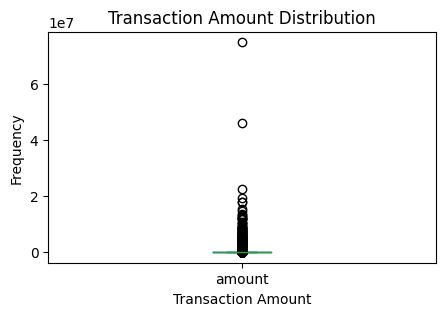

In [ ]:
# Numerical Variable distribution
# plot_numerical_variable_distribution(df_tran, 'tuid', lstTranFetrsNum)
print(df_tran[lstTranFetrsNum].describe())
df_tran[lstTranFetrsNum].plot(kind='box', figsize=(5, 3))
plt.title('Transaction Amount Distribution')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

**Outlier Alert**: There are possible outliers values (atleast two points). We will look into the specific customer transaction details and analyze further.

In [ ]:
# Let's analyze these high value tranactions
df_tran.sort_values('amount', ascending=False)[['customer_id', 'tuid','amount']].head(10)

,customer_id,tuid,amount
1295631,XHEPgIh1qznSFR+bCQCHS4sbYxd10qHuwj7vQD8Cu2c=,a+iHotpAb/dBBjsYUNPyYquGe/xF0qGb0Vd0jAHFouc=,75000000.0
464479,W5ZV25a66HPxvXb1iq8eNC0lJePUHdCmZ9GSKVcXzd0=,VpfGiBHIGE0s1vibISn7VnzeD2eFMXkI0hDXJCz10cs=,46237870.0
1041482,iqJiSkH4lkPv+PAjveSl3g5WpVJ/7X7CeA81tSqnK/A=,qB3es8gZ0aYiJltr4DfBz8olu4rSoOx1SigvAhx5KoY=,22604600.0
1485857,4HUEF5l/HoiO+toZo+//NUqi5noiUYyJmDkjd7xbUpw=,i9wFseqWf3kHB0S/7dSHWptLkTpVWhEyjUNljPq0iuA=,19239682.0
1159697,p3Sr6CqjOXfYAENBheZa0UYki6SPRsgelYRDBhpgK2k=,5cKqhRn+aaksLjjvR7qHjI5PQvcNIeYfvyg/EKNqy28=,17842244.0
688999,ssYUc8O/ZM7TjYOj0K4lu6lhTnGyOMoHeiRkzGA0OJc=,1A7ldhYerTUXkbHvph81Z8+8Lb7QtxIg5rzgPmTDubE=,17842112.0
1191602,FUO4bOQTcM4VEX6g6T1NZ5/RXcpumV6Eu08XeIROe38=,dUN+94MiM9chjCNOTFyMfpk/JddZn+Trv0qt4bAGI+I=,15307230.0
402065,dpyNoVBXa5C1ra2cQunxX16KB8xYg/GDkanKwmQ/Hig=,rIiAnSYeJirD3SsJHZODV7zQbgfVjvfufdE2RaSzz1c=,14775050.0
1172480,hg2vXrqJMdSY45YlzIcB3zkfq/fMxvFwVbcYHp4r6Mg=,WyKaJir4cU8NRKhJjTCghTW0o+SCl8krJft+GY/soFI=,13741500.0
772420,xeQx5/Q0Az+L6T90zQxeNmozxalPHtprP/JRLKWV6W4=,spQrHhlmBk7b+Bir3Iku5aWxpHQh5C845Bd+ohg5LBk=,13237230.0


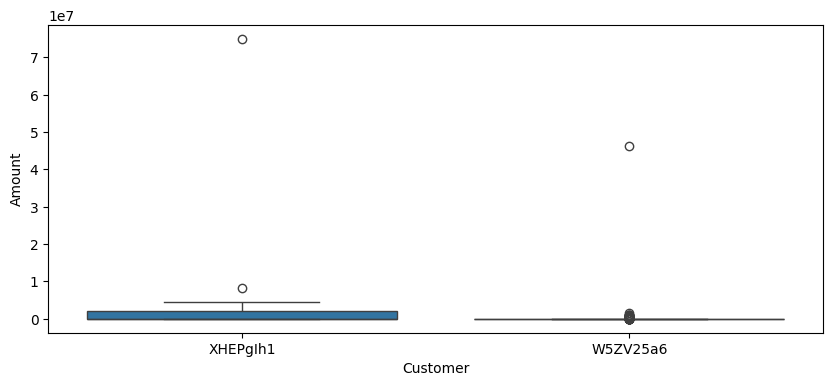

In [ ]:
# Let's check for all transactions for these customers

# Define the customer IDs
sCustomerID1 = 'XHEPgIh1qznSFR+bCQCHS4sbYxd10qHuwj7vQD8Cu2c='
sCustomerID2 = 'W5ZV25a66HPxvXb1iq8eNC0lJePUHdCmZ9GSKVcXzd0='

# Filter the data for each customer
data1 = df_tran[df_tran['customer_id'] == sCustomerID1]['amount']
data2 = df_tran[df_tran['customer_id'] == sCustomerID2]['amount']

# Combine the data into a single DataFrame for plotting
combined_data = pd.DataFrame({
    'Customer': [sCustomerID1[:8]] * len(data1) + [sCustomerID2[:8]] * len(data2),
    'Amount': pd.concat([data1, data2])
})

# Create the box plots
plt.figure(figsize=(10, 4))
sns.boxplot(x='Customer', y='Amount', data=combined_data)

# Show the plot
plt.show()

In [ ]:
# Let's exclude those high value transactions
print(df_tran.shape)
df_tran = df_tran[df_tran['amount']<46237870]
print(df_tran.shape)

(1496176, 16)
(1496174, 16)


## **Step 2: Data Preparation**

### **Data Filters**
- Only Pick Customers whose profile is VERIFIED.
- Exclude Failed and ZERO value transactions.

In [ ]:
# Only Pick Customers whose profile is VERIFIED
print(df_cust.shape)
df_cust = df_cust[df_cust['profileStatus']=='VERIFIED']
print(df_cust.shape)

(4526, 25)
(3904, 25)


In [ ]:
# Exclude Failed and Zero Value transactions
print(df_tran.shape)
df_tran = df_tran[(df_tran['failedDate'].isna()) & (df_tran['amount']>0)]
print(df_tran.shape)

(1496174, 16)
(1117002, 16)


### **Feature Engineering**

#### **Customers**

In [ ]:
### Format Date Variables
# Convert date variables to datetime format
df_cust['dob'] = df_cust['dob'].apply(format_str_to_date)
df_cust['createdAt'] = df_cust['createdAt'].apply(format_str_to_date)
df_cust['firstSwitchTimestamp'] = df_cust['firstSwitchTimestamp'].apply(format_str_to_date)
df_cust['firstPayrollTimestamp'] = df_cust['firstPayrollTimestamp'].apply(format_str_to_date)
df_cust['userVerifiedTimestamp'] = df_cust['userVerifiedTimestamp'].apply(format_str_to_date)
df_cust['physical_card_activated_at'] = df_cust['physical_card_activated_at'].apply(format_str_to_date)
df_cust['virtual_card_activated_at'] = df_cust['virtual_card_activated_at'].apply(format_str_to_date)

In [ ]:
# Standardize this field by converting to all lower case
df_cust['context_device_type'] = df_cust['context_device_type'].str.lower()

# Fix UserType variable with Verified Age
df_cust['userType'] = df_cust['ageAtUserVerified'].apply(lambda x: 'minor' if x<=18 else 'individual')

# Create New Features from DateTime Variables
df_cust['days_to_first_switch']      = (df_cust['firstSwitchTimestamp'] - df_cust['createdAt']).dt.days
df_cust['days_to_first_payroll']     = (df_cust['firstPayrollTimestamp'] - df_cust['createdAt']).dt.days
df_cust['days_to_phy_card_activate'] = (df_cust['physical_card_activated_at'] - df_cust['createdAt']).dt.days
df_cust['days_to_vir_card_activate'] = (df_cust['virtual_card_activated_at'] - df_cust['createdAt']).dt.days

In [ ]:
lstDropFetrs += ['firstSwitchTimestamp','firstPayrollTimestamp','userVerifiedTimestamp',
                 'profileStatus', 'dob','createdAt',
                 'physical_card_activated_at','virtual_card_activated_at']

In [ ]:
df_cust.drop(lstDropFetrs, axis=1, inplace=True)
# df_cust.head()

#### **Transactions**

In [ ]:
# Change Data Type
df_tran['effectiveTimestamp'] = df_tran['effectiveTimestamp'].apply(format_str_to_date)

# Combine all CUSTODIAL Wallet types into one category
df_tran['walletType'] = df_tran['walletType'].apply(lambda x: 'CUSTODIAL' if x not in ['PRIMARY','SAVINGS'] else x)

**Transaction Dates**
- Consider 1st transaction date as the 1st Account Activity Day and determine 15th Date and Year End Date from the first transaction date.
- Aggregate Revenue by Customers to get 15Days Revenue and 1Year Revenue

In [ ]:
# Get the 1st and last transaction dates (min/max)
df_tran_grp_dt = df_tran.groupby(['customer_id']) \
                .agg({'effectiveTimestamp': ['min', 'max']}) \
                .reset_index()
df_tran_grp_dt.columns = ['customer_id', 'dt_tran_1st', 'dt_tran_max']

# Derive 15th and 365th Date
df_tran_grp_dt['dt_tran_1st'] = df_tran_grp_dt['dt_tran_1st'].dt.date
df_tran_grp_dt['dt_tran_15d'] = df_tran_grp_dt['dt_tran_1st'] + pd.to_timedelta(15,  unit='D')
df_tran_grp_dt['dt_tran_1Yr'] = df_tran_grp_dt['dt_tran_1st'] + pd.to_timedelta(365, unit='D')
df_tran_grp_dt['dt_tran_max'] = df_tran_grp_dt['dt_tran_max'].dt.date
# df_tran_grp_dt

In [ ]:
# Data with Aggregated dates by customer (1st, 15th, 365th)
d1 = df_tran_grp_dt[['customer_id','dt_tran_1st','dt_tran_15d','dt_tran_1Yr']]

# Data with All transactions by Customer
d2 = df_tran[['customer_id', 'tuid', 'effectiveTimestamp', 'amount', 'transactionType', 'walletType']]

# Convert datetime to date format
d2['dt_tran'] = d2['effectiveTimestamp'].dt.date
d2.drop('effectiveTimestamp', axis=1, inplace=True)

**Revenue Aggregate (First 15 Days)**

In [ ]:
# Merge and Filter transactions for first 15 Days
d_merge = d1.merge(d2, on='customer_id')
d_merge = d_merge[(d_merge['dt_tran']>=d_merge['dt_tran_1st']) & (d_merge['dt_tran']<=d_merge['dt_tran_15d'])]

# Aggregate transactions to get 15Days (Total Revenue and Number of Transaction)
df_tran_rev_agg_15d = d_merge.groupby('customer_id').agg({'amount':'sum', 'tuid':'count'}).reset_index()
df_tran_rev_agg_15d.columns=['customer_id', 'tot_revenue_15d', 'cnt_tran_15d']

# Derive Revenue per transaction within 15Days
df_tran_rev_agg_15d['agg_revenue_15d'] = (df_tran_rev_agg_15d['tot_revenue_15d']/df_tran_rev_agg_15d['cnt_tran_15d']).round()

# df_tran_rev_agg_15d

**Wallet Type Aggregate (First 15 Days)**

In [ ]:
# Wallet Type Aggregate
df_tran_rev_agg_wtyp_15d = d_merge.pivot_table(
    index='customer_id',
    columns='walletType',
    values=['tuid', 'amount'],
    aggfunc={'tuid': 'count', 'amount': ['sum','mean']}
).round()

# Flatten the column multi-index
df_tran_rev_agg_wtyp_15d.columns = ['_'.join(col).strip() for col in df_tran_rev_agg_wtyp_15d.columns.values]

# Reset the index to make customer_id a column
df_tran_rev_agg_wtyp_15d = df_tran_rev_agg_wtyp_15d.reset_index()
df_tran_rev_agg_wtyp_15d = df_tran_rev_agg_wtyp_15d.fillna(0)
# df_tran_rev_agg_wtyp_15d

**Transaction Type Aggregate (First 15 Days)**

In [ ]:
# Transaction Type Aggregate
df_tran_rev_agg_ttyp_15d = d_merge.pivot_table(
    index='customer_id',
    columns='transactionType',
    values=['tuid', 'amount'],
    aggfunc={'tuid': 'count', 'amount': ['sum','mean']}
).round()

# Flatten the column multi-index
df_tran_rev_agg_ttyp_15d.columns = ['_'.join(col).strip() for col in df_tran_rev_agg_ttyp_15d.columns.values]

# Reset the index to make customer_id a column
df_tran_rev_agg_ttyp_15d = df_tran_rev_agg_ttyp_15d.reset_index()
df_tran_rev_agg_ttyp_15d = df_tran_rev_agg_ttyp_15d.fillna(0)
# df_tran_rev_agg_ttyp_15d

**Revenue Aggregate (First 1 Year)**

In [ ]:
d_merge = d1.merge(d2, on='customer_id')
d_merge = d_merge[(d_merge['dt_tran']>=d_merge['dt_tran_1st']) & (d_merge['dt_tran']<=d_merge['dt_tran_1Yr'])]
df_tran_rev_agg_1y = d_merge.groupby('customer_id')['amount'].sum().reset_index()
df_tran_rev_agg_1y.columns=['customer_id', 'tot_revenue_1Yr']

**Combine All Aggrgates**

In [ ]:
# Combine All aggrgated data
df_tran_rev_agg = df_tran_rev_agg_15d.merge(df_tran_rev_agg_wtyp_15d, on='customer_id')
df_tran_rev_agg = df_tran_rev_agg.merge(df_tran_rev_agg_ttyp_15d, on='customer_id')
df_tran_rev_agg = df_tran_rev_agg.merge(df_tran_rev_agg_1y[['customer_id','tot_revenue_1Yr']], on='customer_id')
# df_tran_rev_agg

**Create Customer Tier**

In [ ]:
# Create Tier
df_tran_rev_agg['customer_tier'] = pd.qcut(df_tran_rev_agg['tot_revenue_1Yr'], q=3, labels=['Low', 'Medium', 'High'])

# Verify Status
df_tran_rev_agg.groupby('customer_tier').agg({'customer_id':'count',
                                          'tot_revenue_1Yr': ['min','max','mean','median','sum']}).round(0)

customer_id tot_revenue_1Yr                           \
                    count             min          max        mean   
customer_tier                                                        
Low                  1194             1.0     451207.0    111315.0   
Medium               1193        452120.0    5945771.0   2310010.0   
High                 1194       5966289.0  197150832.0  22004127.0   

                                         
                   median           sum  
customer_tier                            
Low               59477.0  1.329099e+08  
Medium          1848136.0  2.755842e+09  
High           15734260.0  2.627293e+10

In [ ]:
fig = px.box(
    df_tran_rev_agg,
    x='customer_tier',
    y='tot_revenue_1Yr',
    width=800,
    height=400
)
# Update layout for better visualization
fig.update_layout(
    title_text="Customer Tier by First 1 Year Revenue",
    xaxis_title="Customer Tier",
    yaxis_title="Revenue 1Year",
    showlegend=False
)

# Show the figure
fig.show()

**Combine Customer and Transaction Datasets**

- Combine separately processed Customer and Transaction Datasets.
- Drop columns marked for deletion in prior analysis steps.

In [ ]:
df_cust_tran = pd.merge(df_cust, df_tran_rev_agg, on='customer_id')

print(df_cust_tran.shape)
# df_cust_tran.head()

(3135, 51)


In [ ]:
# Attrition - There are customers whose 1st 15D revenue and 1Y revenue are same.
# These could be potential case of soft attrition or may be some long term investment products.
# We can skip those customers.
print(df_cust_tran.shape)
df_model = df_cust_tran[df_cust_tran['tot_revenue_1Yr'] != df_cust_tran['tot_revenue_15d']]
print(df_model.shape)

(3135, 51)
(2627, 51)


#### **Multi Colinearity Check**

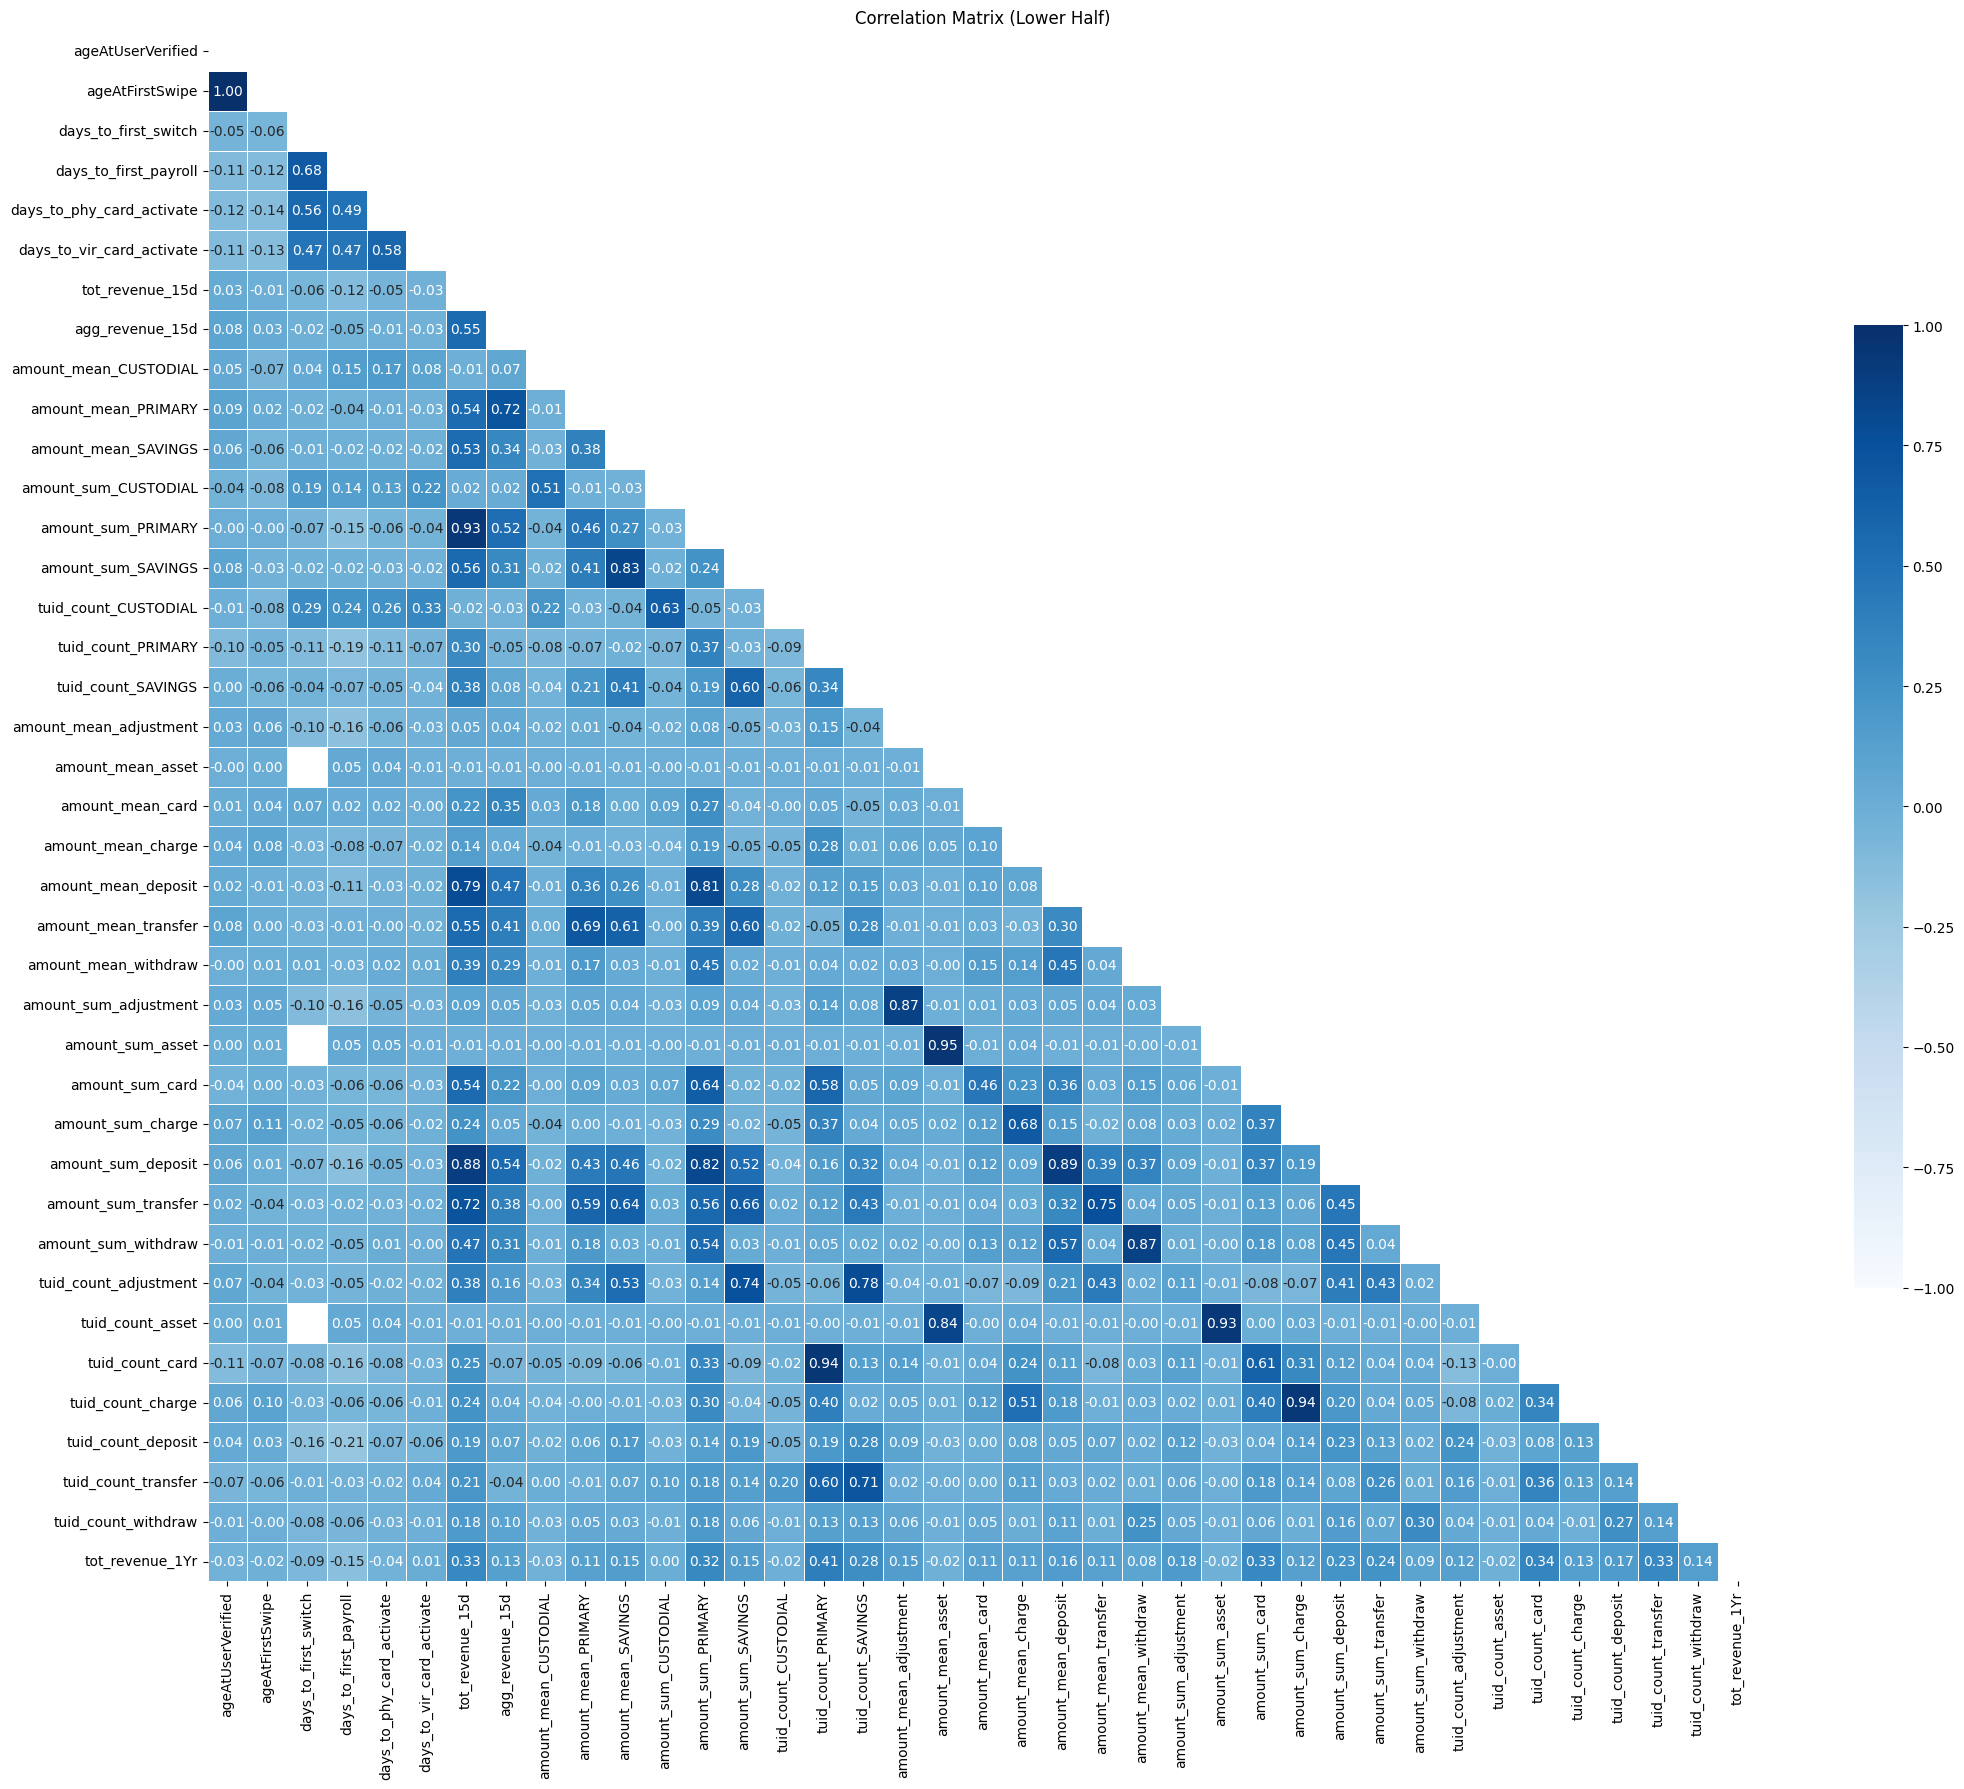

In [ ]:
corr_matrix = df_model.select_dtypes(include='float64').corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(25, 25))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='Blues', vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Add a title
plt.title('Correlation Matrix (Lower Half)')

# Show the plot
plt.show()

In [ ]:
# Set the threshold
threshold = 0.9

# Find index pairs of highly correlated features
high_corr_var = np.where(np.abs(corr_matrix) > threshold)
high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y]

# Remove duplicate pairs (since correlation matrix is symmetric)
high_corr_pairs = list(set(tuple(sorted(pair)) for pair in high_corr_pairs))

# Display highly correlated pairs
print("Highly Correlated Pairs:", high_corr_pairs)

Highly Correlated Pairs: [('amount_sum_PRIMARY', 'tot_revenue_15d'), ('amount_mean_asset', 'amount_sum_asset'), ('amount_sum_charge', 'tuid_count_charge'), ('ageAtFirstSwipe', 'ageAtUserVerified'), ('tuid_count_PRIMARY', 'tuid_count_card'), ('amount_sum_asset', 'tuid_count_asset')]


In [ ]:
# Create a set to hold columns to drop
columns_to_drop = set()

for col1, col2 in high_corr_pairs:
    # Add one of the columns to the set
    columns_to_drop.add(col2)

# Drop the columns
df_model = df_model.drop(columns=columns_to_drop)

# Display the reduced DataFrame
print("Columns dropped:", columns_to_drop)
# print("Reduced DataFrame:\n", df_reduced)

Columns dropped: {'ageAtUserVerified', 'amount_sum_asset', 'tuid_count_card', 'tuid_count_asset', 'tuid_count_charge', 'tot_revenue_15d'}


## **Step 3: Modeling**

### **Regression**
Predict 1Y Revenue

In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.tree import plot_tree

def plot_confusion_matrix(cm, class_labels):
  # Plot the confusion matrix
  plt.figure(figsize=(3, 3))  # Adjust the figsize to reduce plot size
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
  plt.title('Confusion Matrix for Multi-Class Classification')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

def get_feature_importance(model_pipeline, sType):
  # Feature Importance
  # Get the model from the pipeline
  trained_model = model_pipeline.named_steps[sType]

  # Get the feature importances
  importances = trained_model.feature_importances_

  # Get feature names from the preprocessing step
  feature_names = lst_numeric_features + list(model_pipeline.named_steps['preprocessor']
                                          .named_transformers_['cat']
                                          .named_steps['onehot']
                                          .get_feature_names_out(lst_categorical_features))

  # Combine into a DataFrame for better readability
  feature_importance_df = pd.DataFrame({
      'Feature': feature_names,
      'Importance': importances
  }).sort_values(by='Importance', ascending=False)

  df_fi = feature_importance_df.head(15)

  # Create a bar plot with labels
  fig = px.bar(df_fi.sort_values('Importance'), x='Importance', y='Feature', text_auto=True,
              #labels={'index': 'Variables', 'x': '%Missing Values'},
              title='Feature Importance')

  # Show the plot
  fig.show()

In [ ]:
# Let's list down the features
sIDFeature     = 'customer_id'
sTargetFeature = 'tot_revenue_1Yr'
sClassFeature  = 'customer_tier'

# Columns dropped: {'ageAtUserVerified', 'amount_sum_asset', 'tuid_count_card', 'amount_sum_withdraw',
#                   'tuid_count_asset', 'tuid_count_charge', 'tot_revenue_15d'}

lst_numeric_features = [#'ageAtUserVerified',
                        'ageAtFirstSwipe',
                        'days_to_first_switch', 'days_to_first_payroll',
                        'days_to_phy_card_activate', 'days_to_vir_card_activate', #'tot_revenue_15d',
                        'cnt_tran_15d', 'agg_revenue_15d',

                        'amount_mean_CUSTODIAL', 'amount_mean_PRIMARY', 'amount_mean_SAVINGS',
                        'amount_sum_CUSTODIAL', 'amount_sum_PRIMARY', 'amount_sum_SAVINGS',
                        'tuid_count_CUSTODIAL', 'tuid_count_PRIMARY', 'tuid_count_SAVINGS',

                        'amount_mean_adjustment', 'amount_mean_asset', 'amount_mean_card',
                        'amount_mean_charge', 'amount_mean_deposit', 'amount_mean_transfer','amount_mean_withdraw',

                        'amount_sum_adjustment', #'amount_sum_asset',
                        'amount_sum_card',
                        'amount_sum_charge', 'amount_sum_deposit', 'amount_sum_transfer', #'amount_sum_withdraw',

                        'tuid_count_adjustment', #'tuid_count_asset', 'tuid_count_card','tuid_count_charge',
                        'tuid_count_deposit', 'tuid_count_transfer', 'tuid_count_withdraw']

# Define the preprocessing for the categorical columns
lst_categorical_features = ['state', 'userType', 'context_os_name', 'context_device_model',
                            'context_device_ad_tracking_enabled', 'context_device_manufacturer',
                            'context_device_type', 'context_network_carrier','attributed_channel_verified']

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with median
    ('scaler', StandardScaler())  # Standardize the numerical features
])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode the categorical features
])

# Combine the numeric and categorical transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, lst_numeric_features),
        ('cat', categorical_transformer, lst_categorical_features)
    ])

# Create the full pipeline with a classifier
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['ageAtFirstSwipe',
                                                   'days_to_first_switch',
                                                   'days_to_first_payroll',
                                                   'days_to_phy_card_activate',
                                                   'days_to_vir_card_activate',
                                                   'cnt_tran_15d',
                                                   'agg_revenue_15d',
                                                   'amount_mean_CUSTODIAL',
                                                   'amount_m...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['state', 'userType',
                                                   'context_os_name',
                                                   'context_device_model',
                                                   'context_device_ad_tracking_enabled',
                                                   'context_device_manufacturer',
                                                   'context_device_type',
                                                   'context_network_carrier',
                                                   'attributed_channel_verified'])])),
                ('regressor', RandomForestRegressor())])

In [ ]:
# Split the data into training and testing sets
X = df_model.drop([sIDFeature, sTargetFeature, sClassFeature], axis=1)
y = df_model[sTargetFeature]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train the model
model_pipeline.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model_pipeline.predict(X_test)

# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# print(f'Root Mean Squared Error: {rmse:,.2f}')
print(f'Mean Absolute Error: {mae:,.2f}')
print(f'Mean Absolute Percentage Error: {mape:,.2f}')

# Feature Importance
get_feature_importance(model_pipeline, 'regressor')

Mean Absolute Error: 7,846,998.18
Mean Absolute Percentage Error: 9.66


count    5.260000e+02
mean     9.814179e+06
std      1.583047e+07
min      3.080000e+02
25%      5.118688e+05
50%      3.349313e+06
75%      1.314288e+07
max      1.470828e+08
Name: tot_revenue_1Yr, dtype: float64


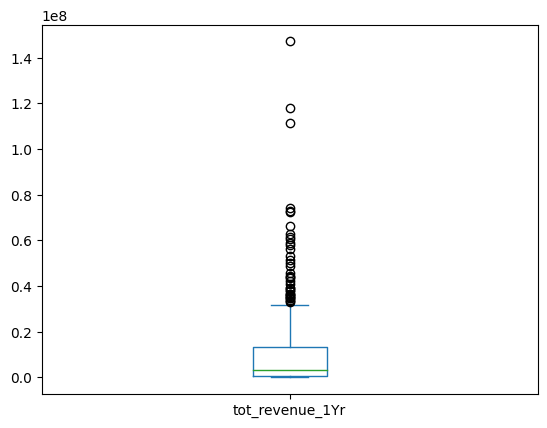

In [ ]:
# Let's take a loot at y_test distribution and compare with model metrics
print(y_test.describe())
y_test.plot(kind='box');

### **Classification**
Predict Customer Tier (High, Medium, Low)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

In [ ]:
# Split the data into training and testing sets
X = df_model.drop([sIDFeature, sTargetFeature, sClassFeature], axis=1)
y = df_model[sClassFeature]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Accuracy: 0.62
Classification Report:               precision    recall  f1-score   support

        High       0.69      0.72      0.70       214
         Low       0.66      0.69      0.68       124
      Medium       0.49      0.45      0.47       188

    accuracy                           0.62       526
   macro avg       0.61      0.62      0.62       526
weighted avg       0.61      0.62      0.61       526

AUC: 0.80


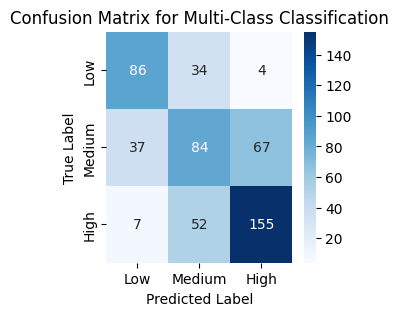

In [ ]:
# Create the full pipeline with a classifier
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Train the model
model_pipeline.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model_pipeline.predict(X_test)

# Predict probabilities for the test set
y_pred_proba = model_pipeline.predict_proba(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
cr = classification_report(y_test, y_pred)

class_labels = ['Low', 'Medium', 'High']
cm  = confusion_matrix(y_test, y_pred, labels=class_labels)

print(f'Accuracy: {acc:.2f}')
print(f'Classification Report: {cr}')
# print(f'Confusion Matrix: {cm}')
print(f"AUC: {auc:.2f}")

# Confusion Matrix Plot
plot_confusion_matrix(cm, class_labels)

# Feature Importance
get_feature_importance(model_pipeline, 'classifier')

## **Step 4: Conclusion**

Two predictive models were developed: a regression model to forecast 12-month revenue and a classification model to categorize customers into value tiers (High, Medium, Low). The regression model achieved a strong performance with a MAPE score of ~10, indicating its reliability in predicting long-term customer value. The classification model also performed well, with an AUC score of ~0.80, effectively distinguishing between high, medium, and low-value customers.

These models provide a robust framework for early identification of high-value customers within the first 15 days of signup. By leveraging these predictions, marketing efforts can be optimized, enabling more strategic allocation of acquisition budgets and enhancing overall customer targeting strategies. This data-driven approach is instrumental in maximizing ROI on customer acquisition and improving long-term profitability.

- **Evaluation Metrics**
  - Regression (MAPE)    : ~10
  - Classification (AUC) : ~0.80

- **Important Featues (Regression)**
  - amount_sum_PRIMARY: Total transaction amount in the primary wallet.
  - tuid_cnt_transfer: Number of transfer transactions.
  - days_to_first_payroll: Days from onboarding to first payroll deposit.
  - tuid_cnt_SAVINGS: Number of savings transactions.
  - amount_sum_deposit: Total deposit transaction amount.

- **Important Featues (Classification)**
 - amount_sum_PRIMARY: Total transaction amount in the primary wallet.
 - cnt_tran_15d: Total number of transactions in the first 15 days.
 - amount_sum_deposit: Total deposit transaction amount.
 - amount_mean_deposit: Average deposit transaction amount.
 - amount_sum_card: Total card transaction amount.
